# SECTION 1: DECLARE THE MODULES

In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# SECTION 2: Data import and preprocess
#Run this but dont worry if it does not make any sense Jump to SECTION 3 that is related to your HD task.

In [2]:
DataSet = "Week_5_NSL-KDD-Dataset/training_attack_types.txt"
DataSet

'Week_5_NSL-KDD-Dataset/training_attack_types.txt'

In [3]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate','rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx)) #doesn't contain numbers in above 2 variables

nominal_cols = col_names[nominal_idx].tolist() #gives col names in header names according to number held in idx var
binary_cols = col_names[binary_idx].tolist()   #basically differentating according to type
numeric_cols = col_names[numeric_idx].tolist()

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [4]:
#Processing Training Data
train_file = "Week_5_NSL-KDD-Dataset/KDDTrain+.txt"

train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'].map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

In [5]:
#Processing test Data
test_file = "Week_5_NSL-KDD-Dataset/KDDTest+.txt"

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'].map(lambda x: attack_mapping[x]) #adds column with type defined in mapping
test_df.drop(['success_pred'], axis=1, inplace=True)

<AxesSubplot:>

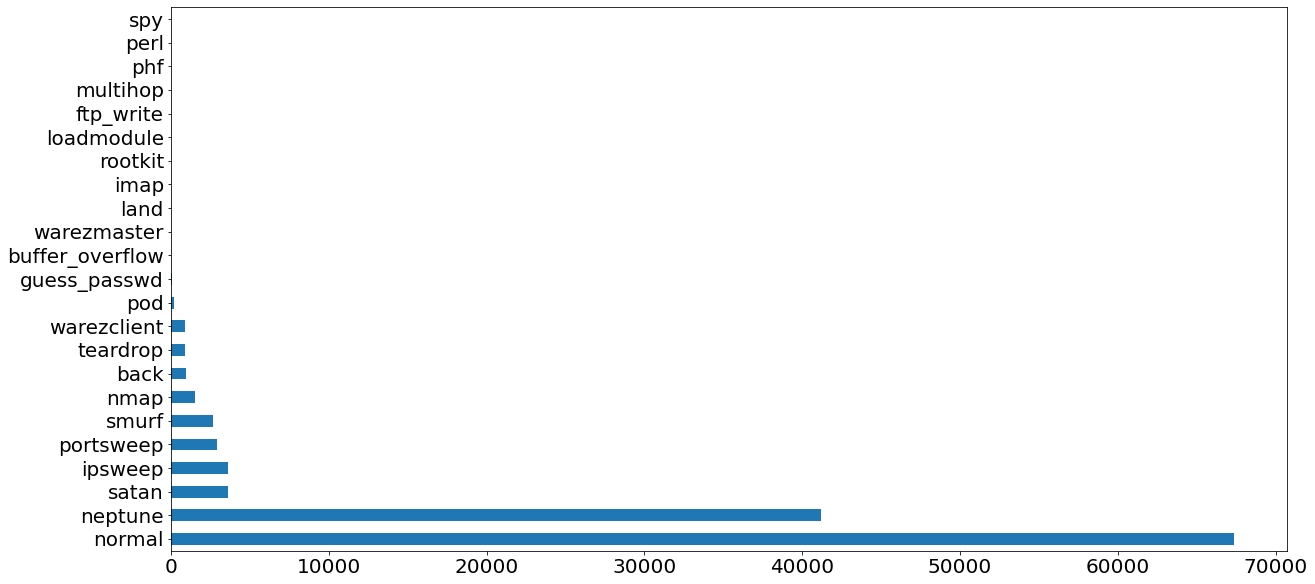

In [6]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

<AxesSubplot:>

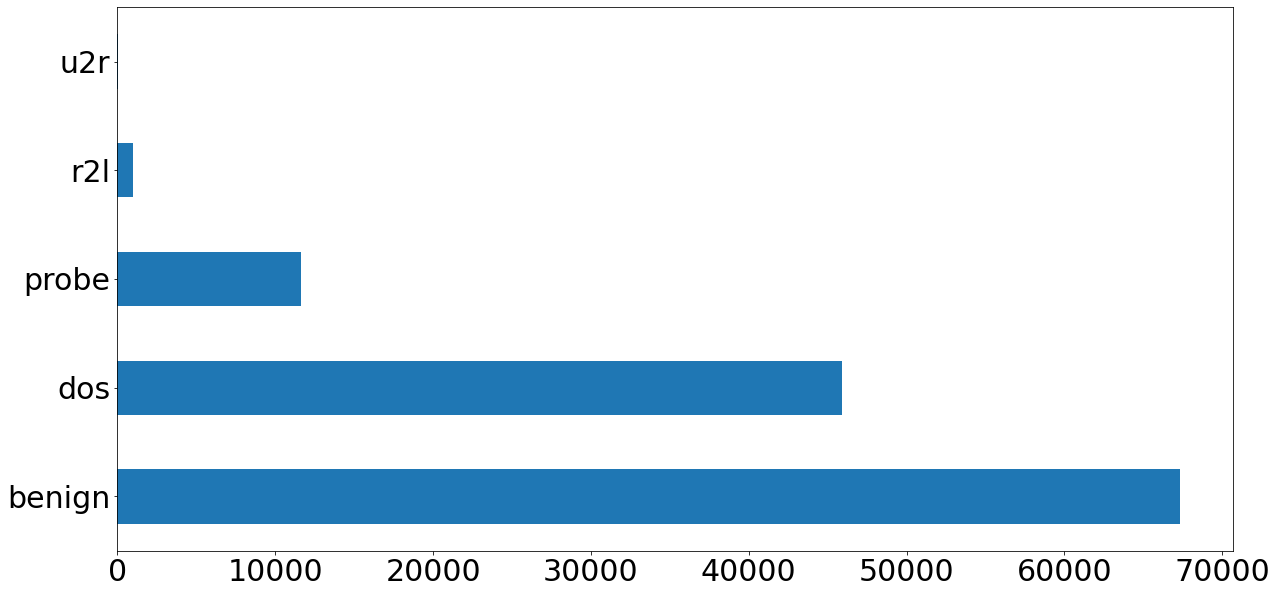

In [7]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

<AxesSubplot:>

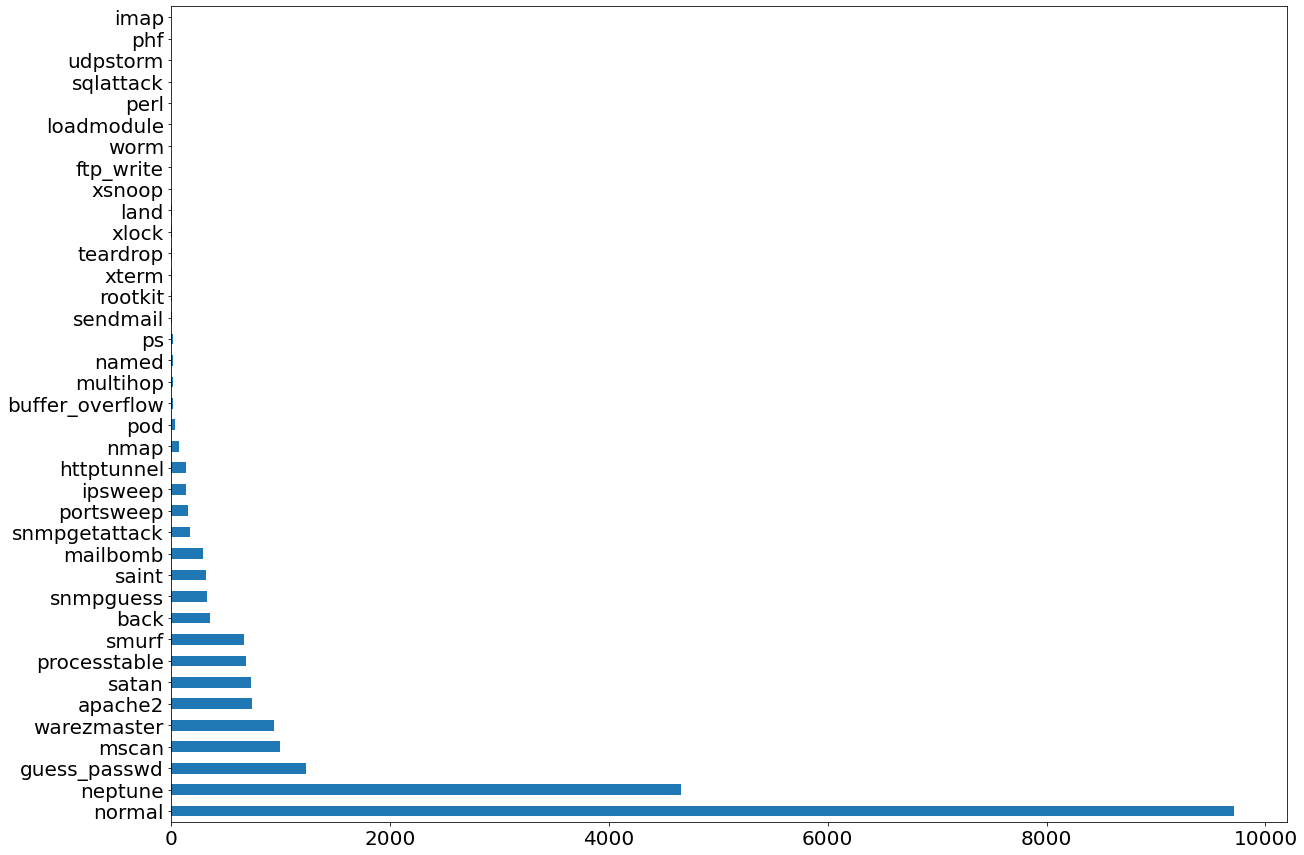

In [8]:
test_attack_types.plot(kind='barh', figsize=(20,15), fontsize=20)

<AxesSubplot:>

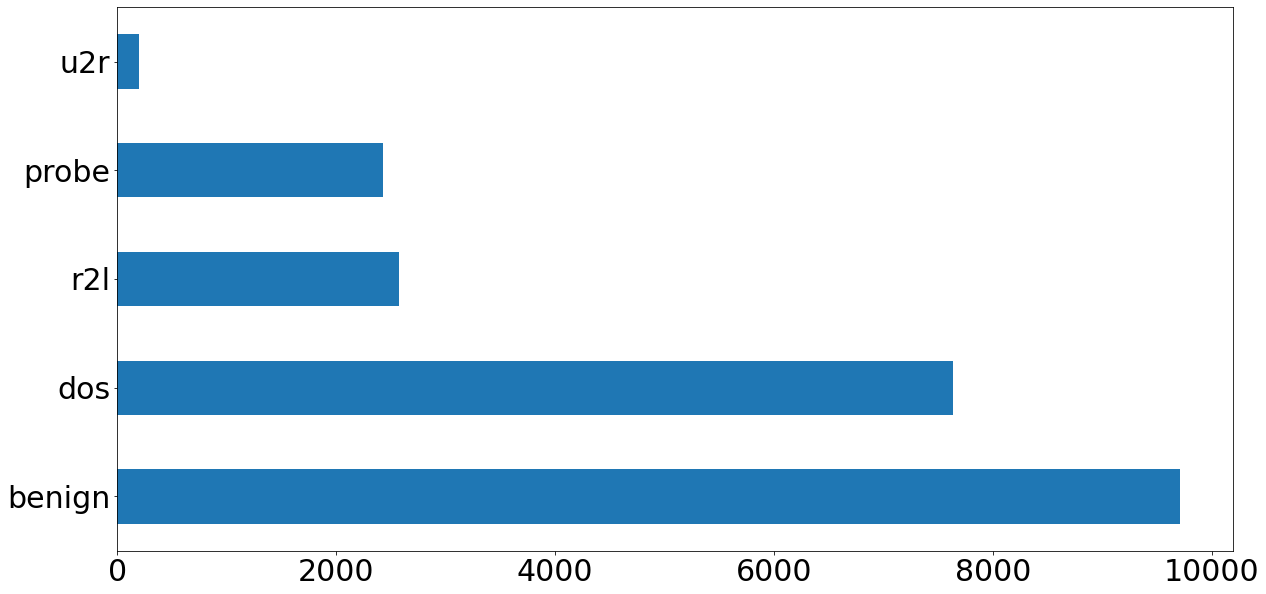

In [9]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

In [10]:
train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [11]:
train_df.groupby(['num_outbound_cmds']).size()
train_df.drop('num_outbound_cmds', axis=1, inplace=True)
test_df.drop('num_outbound_cmds', axis=1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

In [12]:
#Data Preparation
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category', 'attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis=1)

combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [13]:
train_x.describe()
train_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [14]:
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.259730e+05
mean     2.549477e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [15]:
# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [16]:
# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
dtype: float64

In [17]:
# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [18]:
# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])
train_x[numeric_cols] = standard_scaler.transform(train_x[numeric_cols])
test_x[numeric_cols] = standard_scaler.transform(test_x[numeric_cols])
train_x.describe()

train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

# SECTION 3: Multi class classification
#This is the section where you have to add other algorithms, tune algorithms and visualize to compare and analyze algorithms

In [33]:
# 5-class classification version
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

In [34]:
def output():
    results = metrics.confusion_matrix(test_Y, pred_y)
    error = metrics.zero_one_loss(test_Y, pred_y)
    print("Confusion Matrix:\n", results)
    print("\nZero one loss: ", error)
    print("\nClassification report:\n", metrics.classification_report(test_Y, pred_y, digits=5))

In [35]:
output()

Confusion Matrix:
 [[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]

Zero one loss:  0.2378903477643719

Classification report:
               precision    recall  f1-score   support

      benign    0.66721   0.96437   0.78873      9711
         dos    0.95586   0.78549   0.86234      7636
       probe    0.79026   0.62980   0.70096      2423
         r2l    0.97880   0.10761   0.19391      2574
         u2r    0.78947   0.07500   0.13699       200

    accuracy                        0.76211     22544
   macro avg    0.83632   0.51245   0.53659     22544
weighted avg    0.81487   0.76211   0.73053     22544



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(train_x, train_Y)

pred_y = neigh.predict(test_x)
output()

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_x, train_Y)

pred_y = gnb.predict(test_x)
output()

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)
output()

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf')
svc.fit(train_x, train_Y)

pred_y = svc.predict(test_x)
output()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=17)
rfc.fit(train_x, train_Y)

pred_y = rfc.predict(test_x)
output()

In [ ]:
from sklearn.neural_network import MLPClassifier
neural = MLPClassifier(random_state=17)
neural.fit(train_x, train_Y)

pred_y = neural.predict(test_x)
output()